In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.stats import mode
from scipy.linalg import svd
from collections import defaultdict
from scipy.stats import mode, itemfreq
from scipy import delete
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC as SVM
import operator
from biom import load_table
from random import randint
import seaborn as sns
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, IterativeSVD, MICE
import math
from wpca import WPCA, EMPCA
from gneiss.sort import mean_niche_estimator, niche_sort
from gneiss.util import match
from gneiss.balances import balance_basis
from skbio.stats.composition import (closure, perturb, power, ilr, ilr_inv,inner, perturb_inv, clr, clr_inv, centralize)
from skbio import TreeNode, DistanceMatrix
from scipy.cluster.hierarchy import average
from scipy.spatial.distance import euclidean
import copy
from r_pca import R_pca #alternate completion than fancy impute
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from base_impute import base
from error_impute import error
%matplotlib inline

In [31]:
def fancy_dendrogram(*args, **kwargs):
    
    '''''
    From https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
    '''''
    
    
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [32]:
def convert_biom_to_pandas(table):

    
    '''''
    From gneiss notebooks https://github.com/biocore/gneiss
    '''''

    
    feature_table = pd.DataFrame(np.array(table.matrix_data.todense()).T,
                             index=table.ids(axis='sample'),
                             columns=table.ids(axis='observation'))
    feature_ids = table.ids(axis='observation')
    mapping = {i: table.metadata(id=i, axis='observation')['taxonomy'] for i in feature_ids}
    taxonomy = pd.DataFrame(mapping, 
                            index=['kingdom', 'phylum', 'class', 'order', 
                                   'family', 'genus', 'species']).T
    return feature_table, taxonomy

# Import .biom, taxonomy and meta data

In [51]:
#Mapping

mappingdf= pd.read_table('data/soil_map.txt', index_col=0)
label_save=[]
#save names
map_names= pd.read_csv('data/soil_map.txt', index_col=0)
mappingdf=mappingdf.dropna(subset=['pH'])
mappingdf.sort(['pH'], ascending = [True], inplace = True)

# set sting based netadata to numerical classifiers
classifier_names = mappingdf.columns.values.tolist()
imdex_list = mappingdf.index.values.tolist()
for nm in classifier_names:

    if mappingdf[nm].dtype == np.dtype(object) or mappingdf[nm].dtype == np.dtype(bool) :
        
        # get set of strings in column
        mappingdfList = mappingdf[nm].tolist()
        mappingdflistset = set(mappingdfList)
        mappingdfsetdict={}
        q=0
        # assign each string in set a integer classifier
        for tmpclassify in mappingdflistset:
            mappingdfsetdict[tmpclassify]=q
            q+=1
        label_save.append(mappingdfsetdict)
                    
samplenames = mappingdf.index.values.tolist()
samplenames = map(str, samplenames)

#BIOM

table = load_table('data/88_soils.biom')
read_filter = lambda val, id_, md: sum(val) > 1
table.filter(read_filter, axis='sample') 
table.filter(read_filter, axis='observation')
otu, taxonomy = convert_biom_to_pandas(table)

otu=otu.T

#add taxa names

taxonomy['fg'] = taxonomy['kingdom'].str.cat(taxonomy['family'])
result = pd.concat([otu, taxonomy], axis=1, join='inner')
#otu = result.set_index('fg')

otus_index=[]
for q in range(len(result.index.values)):
    otus_index.append("OTU_%s"%str(q))
otu['new_index']=otus_index
otu = otu.set_index('new_index')
otu=otu.T

# fill any unknown with zero and drop any all zero rows (double check all zeros cause singular matrix)
otu=otu.fillna(0)
otu.isnull().values.any()
otu = otu.loc[(otu.sum(axis=1) != 0), (otu.sum(axis=0) != 0)]

#drop any samples in mapping not in biom
index = otu.index.values.tolist()
indexmappingdf = mappingdf.index.values.tolist()
for checkotu in index:
    check=list(filter(lambda x: checkotu == str(x), indexmappingdf))
    if len(check)>=1:
        continue 
    else:
        otu.drop(str(checkotu),0,inplace=True)

    
#drop any samples in mapping not in mappingdf

index = otu.index.values.tolist()
indexmappingdf = mappingdf.index.values.tolist()
for checkotu in indexmappingdf:
    check=list(filter(lambda x: checkotu == x, index))
    if len(check)>=1:
        continue 
    else:
        mappingdf.drop(checkotu,0,inplace=True)
        
# save data and names from data frame
index = otu.index.values.tolist()
data = otu.as_matrix()
ids = otu.columns.values.tolist()
ids = map(str, ids)

for j in range(len(data[:][:])-1):
    if sum(list(data[j][:])) < 1:
                print(j) 

/Users/cameronmartino/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [34]:
nonzeroscount=np.count_nonzero(data)
sizel = data.shape
totalentr=sizel[0]*sizel[1]
(nonzeroscount/totalentr)

0.06980550449169297

# Remove OTU values at the lowest frequency until density reaches desired value

To simulate the "missing" values in an OTU table density will be lowered from the original OTU table by removing the lowest frequency OTUs in reach sample. 

Note: The sum of any OTU row can not be zero or a singular matrix will be formed, preventing SVD and many of the imputation methods. 

In [38]:
############################  makes most sense (min only) #######################

# removes min value that is greater than zero (checks density) in each iteration randomly chosen 

#density range to run
end=0.02 # final density to test 
begin=0.069 # Begning density of matrix 
step=.01
#data=data.T
#intialize
density_in=[]
RMSE_empca_scores=[]
RMSE_wpca_scores=[]
RMSE_sfi_scores=[]
RMSE_siv_scores=[]
RMSE_sni_scores=[]
RMSE_skn_scores=[]
RMSE_smi_scores=[]
RMSE_szi_scores=[]
Density_empca=[]
Density_wpca=[]
Density_sfi=[]
Density_siv=[]
Density_sni=[]
Density_skn=[]
Density_smi=[]
Density_szi=[]

#radnomly remove values from known matrix and try to impute them 

for d in reversed(np.arange(end,begin,step)):
    otum=data.T.copy()
    nonzeroscount=np.count_nonzero(otum)
    sizel = otum.shape
    totalentr=sizel[0]*sizel[1]
    
    while np.float64((nonzeroscount/totalentr)) > d:
        ########### remove a min ###########
        j=randint(0,len(otum[:][:])-1)
        #make sure row is not all zero (not normally possible and will cause singular matrix in imputation!)
        if sum(list(otum[j][:])) < 1:
            continue 
        m = min(i for i in list(otum[j][:]) if i > 0)
        #make sure removing value will not result in zero row
        if sum(list(otum[j][:])) == m:
            continue 
        otum[j][list(otum[j][:]).index(m)]=0
        #check if under-dense 
        nonzeroscount=float(np.count_nonzero(otum))
        sizel = otum.shape
        totalentr=float(sizel[0])*float(sizel[1])
        
    # coherce float the unknown
    print("OTU table of %f generated"%d)
    otum=otum.T.astype(np.float64)

    # make zero unknown for fancy impute, avoid singular matrix by taking transpose 
    otum2=otum.T.copy()
    otum2=otum2.astype(np.float64)
    otum2[otum2 == 0] = np.nan #make unknown nan 

    #WPCA and EMPCA 
    weight = otum.copy()
    for i in range(len(otum2.T)):
        for j in range(len(otum2.T[i])):
            if otum2.T[i][j]==0:
                weight[i][j]=0
            else:
                weight[i][j]=100
            
    print("Running EMPCA")
    EMPCAi = EMPCA(n_components=3).fit_reconstruct(otum,weight)
    print("Running WPCA")
    WPCAi = EMPCA(n_components=3).fit_reconstruct(otum,weight)
    
    #nuclear norm
    
    print("Running Nuclear Norm Minimization") 
    iteration_used=100000000
    rpca = R_pca(otum)
    sni, S = rpca.fit(max_iter=iteration_used, iter_print=int(iteration_used/4))
    sni=abs(sni)
    
    #scale for fancy 
    # sometimes useful for low-rank imputation methods
    biscaler = BiScaler(center_rows=False,center_columns=False,scale_rows=False,scale_columns=False,min_value=0,max_value=(np.amax(otum)),max_iters=500,tolerance=0.00001,verbose=True)
    # rescale columns to have zero mean and unit variance
    otum2_normalized = biscaler.fit_transform(otum2.T)

    # fancy impute and zeros
    print("Running soft impute")
    sfi=SoftImpute(shrinkage_value=None,convergence_threshold=0.00001,max_iters=1000,max_rank=min(data.shape),n_power_iterations=1,init_fill_method="zero",min_value=0,max_value=(np.amax(otum2_normalized)),normalizer=None,verbose=False).complete(otum2_normalized.T)
    sfi=biscaler.inverse_transform(sfi.T)
    print("Running Iterative SVD")
    siv=IterativeSVD(rank=(min(data.shape)-1),convergence_threshold=0.00001,max_iters=1000,gradual_rank_increase=True,svd_algorithm="arpack",init_fill_method="zero",min_value=0,max_value=(np.amax(otum2_normalized)),verbose=False).complete(otum2_normalized.T)
    siv=biscaler.inverse_transform(siv.T)
    print("Running KNN")
    skn=KNN(k=12,orientation="rows",use_argpartition=True,print_interval=100,min_value=0,max_value=(np.amax(otum2_normalized)/10),normalizer=None,verbose=False).complete(otum2_normalized.T)
    skn=biscaler.inverse_transform(skn.T)
    print("Running MICE")
    smi=MICE(visit_sequence='monotone',n_imputations=100,n_burn_in=40,n_pmm_neighbors=40,impute_type='col',n_nearest_columns=np.infty,init_fill_method="mean",min_value=0,max_value=(np.amax(otum2_normalized)),verbose=False).complete(otum2_normalized.T)              
    smi=biscaler.inverse_transform(smi.T)
    print("Imputing by filling with zeros for base comparison")
    szi=base.zeros(otum2.T)
    
    ############# save the results  ##############
    
    ###### density in (after removed values) ####
    density_in.append(error.get_density(otum))
    
    ###### density imputed ####
    Density_empca.append(error.get_density(EMPCAi))
    Density_wpca.append(error.get_density(WPCAi))
    Density_sfi.append(error.get_density(sfi))
    Density_siv.append(error.get_density(siv))
    Density_sni.append(error.get_density(sni))
    Density_skn.append(error.get_density(skn))
    Density_smi.append(error.get_density(smi))
    Density_szi.append(error.get_density(szi))
    
    ##### RMSE of imputed values ####
    missing_mask = np.isnan(otum2.T) #masking 
    RMSE_empca_scores.append(error.RMSE(data,EMPCAi,missing_mask))
    RMSE_wpca_scores.append(error.RMSE(data,WPCAi,missing_mask))
    RMSE_sfi_scores.append(error.RMSE(data,sfi,missing_mask))
    RMSE_siv_scores.append(error.RMSE(data,siv,missing_mask))
    RMSE_sni_scores.append(error.RMSE(data,sni,missing_mask))
    RMSE_skn_scores.append(error.RMSE(data,skn,missing_mask))
    RMSE_smi_scores.append(error.RMSE(data,smi,missing_mask))
    RMSE_szi_scores.append(error.RMSE(data,szi,missing_mask))

OTU table of 0.060000 generated
Running EMPCA
Running WPCA
Running Nuclear Norm Minimization
iteration: 1, error: 502.6675077606266
iteration: 51, error: 0.018550482668914892
[BiScaler] Initial log residual value = -inf
[BiScaler] No room for improvement
Running soft impute
Running Iterative SVD
Running KNN
[KNN] Warning: 415406/461296 still missing after imputation, replacing with 0
Running MICE
Imputing by filling with zeros for base comparison
OTU table of 0.050000 generated
Running EMPCA
Running WPCA
Running Nuclear Norm Minimization
iteration: 1, error: 449.27475790996095
iteration: 51, error: 0.026869737229470933
[BiScaler] Initial log residual value = -inf
[BiScaler] No room for improvement
Running soft impute
Running Iterative SVD
Running KNN
[KNN] Warning: 407575/461296 still missing after imputation, replacing with 0
Running MICE
Imputing by filling with zeros for base comparison
OTU table of 0.040000 generated
Running EMPCA
Running WPCA
Running Nuclear Norm Minimization
iter

In [39]:
#save results as dataframe 
RMSEmapping = pd.DataFrame({'Density': density_in,'EMPCA': RMSE_empca_scores,'MICE': RMSE_smi_scores,'WPC': RMSE_wpca_scores,'Soft Impute': RMSE_sfi_scores,'Iterative SVD': RMSE_siv_scores,'Nuclear Norm Rank Minimization': RMSE_sni_scores,'K nearest neighbors': RMSE_skn_scores,'Zeros': RMSE_szi_scores})   
RMSEmapping.set_index(['Density'], inplace=True)
Out_density = pd.DataFrame({'density': density_in,'EMPCA': Density_empca,'MICE': Density_smi,'WPC': Density_wpca,'Soft Impute': Density_sfi,'Iterative SVD': Density_siv,'Nuclear Norm Rank Minimization': Density_sni,'K nearest neighbors': Density_skn,'Zeros': Density_szi})   
Out_density.set_index(['density'], inplace=True)

# RMSE Between Each Matrix

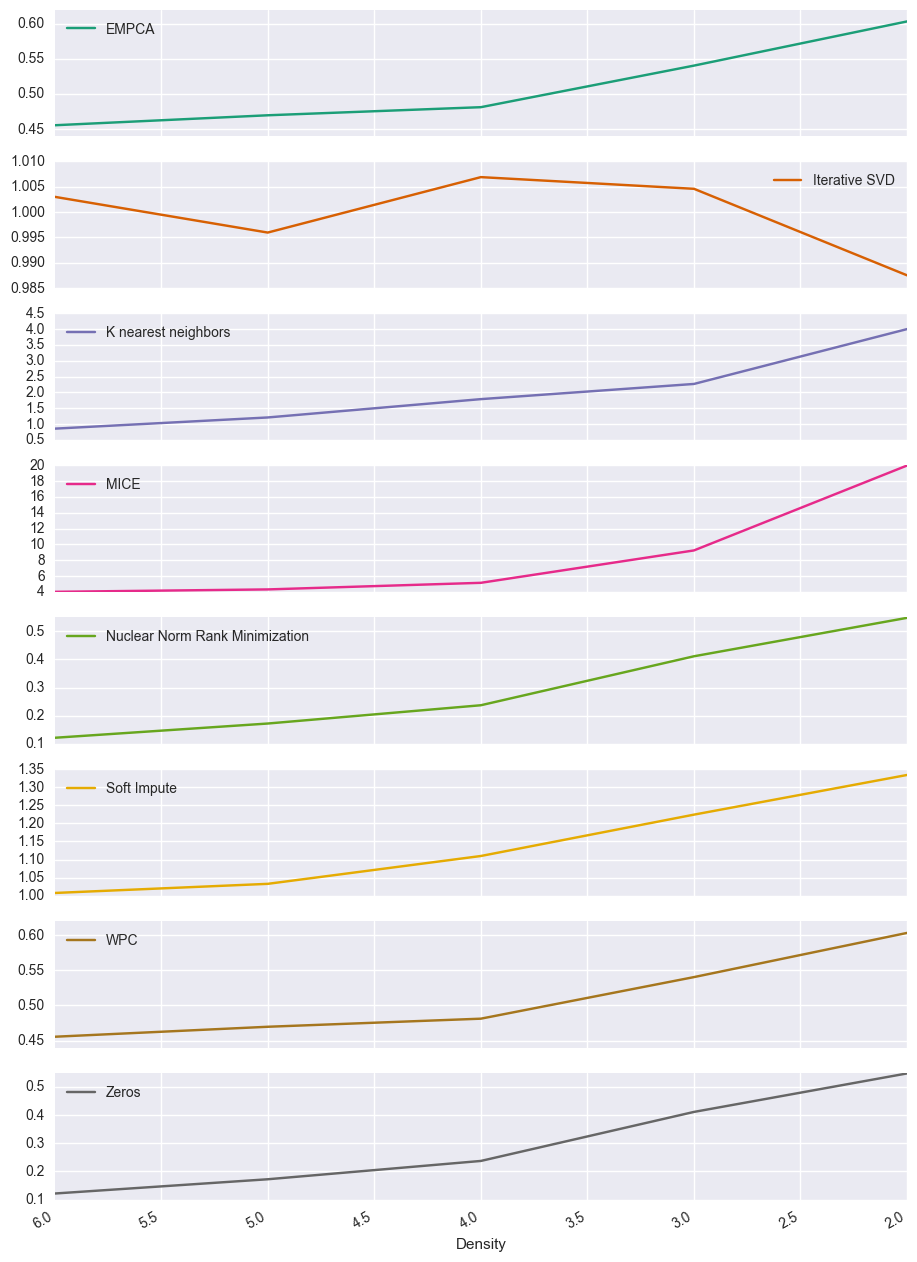

In [40]:
RMSEmapping.plot(kind='line',subplots=True,colormap="Dark2",sharex=True,sharey=False, figsize=(11, 17))
plt.show()


 In general as values are removed all methods increase in the RMSE error to the original matrix. The method used to remove values is very important. Only low frequency OTUs in each sample are removed to simulate the under or small segment sampling used in 16S studies. Because of this the zero method of imputation has a low RMSE or high accuracy. Zeros minimize the probability of being wrong by guessing the smallest possible value of zero. Nuclear Norm Rank Minimization by Convex Optimized Decomposition had the same scores as the zeros. The only downside to this method is although it is exact it does not scale well with large datasets. The next lowest RMSE are Soft Impute, WPCA, EMPCA and Iterative SVD. These may be possible contenders due to their scaleability with large datasets. 

# Density after imputation

Although zero imputation is widely used and has a low RMSE at low densities it produces very sparse matrices preventing the use of many powerful statistical tools. Below you can see at each input density (x-axis) the output density for all imputations methods is ~100% dense with exception of the k-Nearest Neighbors method. While the zero imputation adds sparsity.

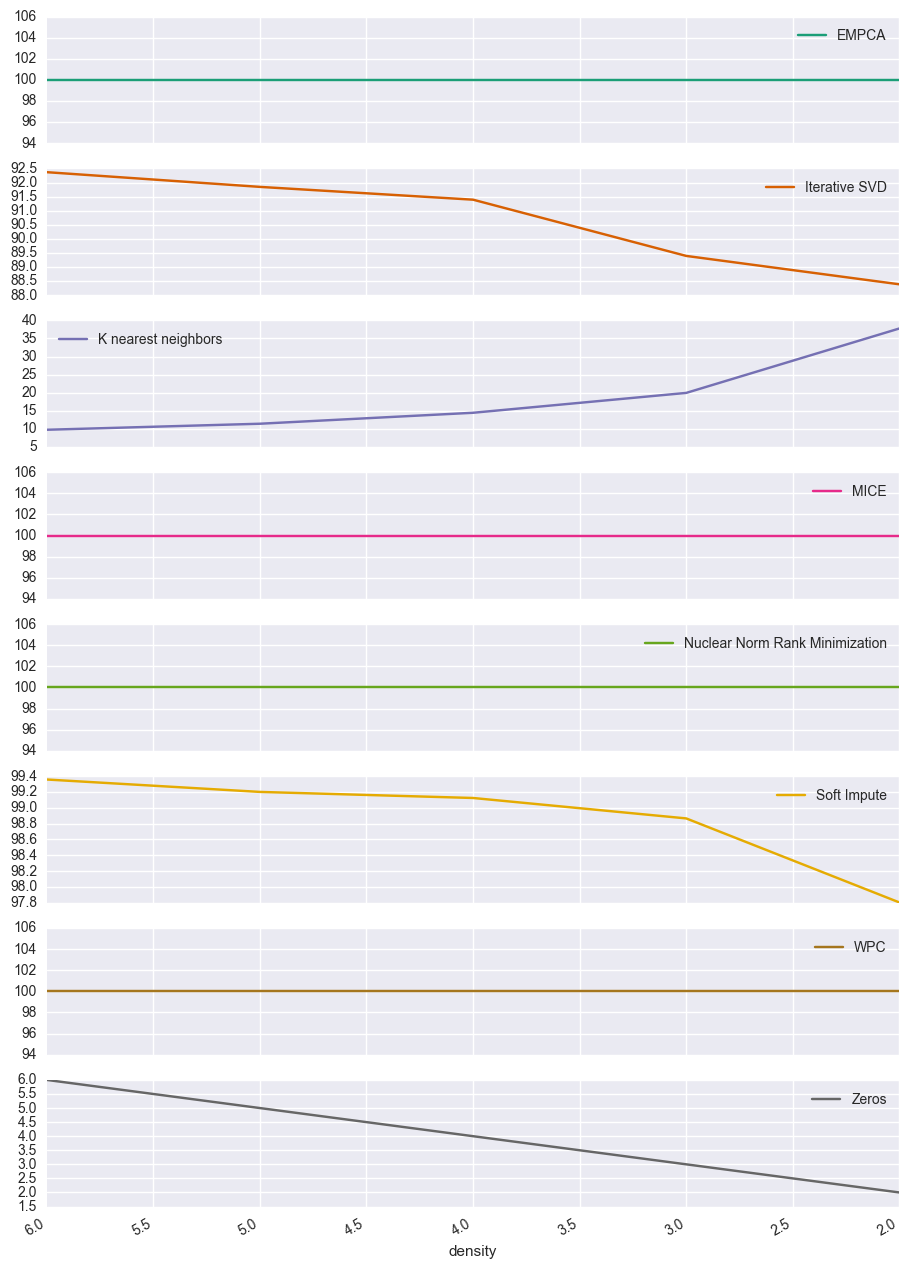

In [41]:
Out_density.plot(kind="line",subplots=True,colormap="Dark2", figsize=(11, 17))
plt.show()

# Visualize pH trend in Completion

RMSE can seem abstract so lets see how the pH trend in these soil samples is maintained while also creating a fully dense matrix using Soft Impute.

In [44]:
#build dataframe and sort the pH niche 
observed_table=niche_sort(otu, mappingdf.pH)
otummapping = pd.DataFrame(otum, columns=otu.columns.tolist(),index=otu.index.tolist())
observed_table_m = niche_sort(otummapping, mappingdf.pH)
observed_table_m=observed_table_m[observed_table.columns.tolist()]
new_otu_sni = pd.DataFrame(sfi, columns=otu.columns.tolist(),index=otu.index.tolist())
observed_table_sni = niche_sort(new_otu_sni, mappingdf.pH)

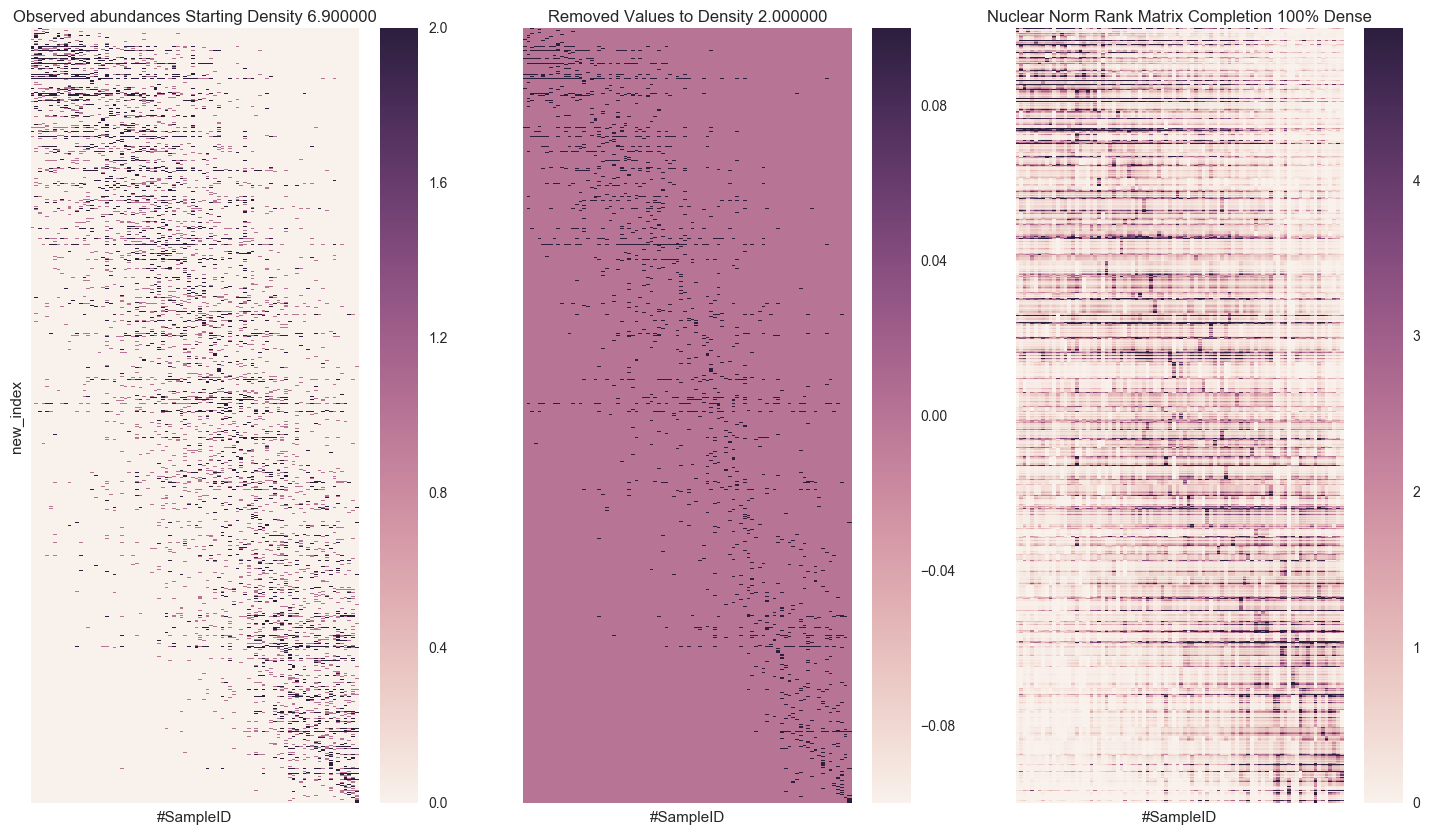

In [602]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(18, 10))
sns.heatmap(observed_table.T, robust=True,vmin=0, ax=ax1)
sns.heatmap(observed_table_m.T, robust=True,vmin=0, ax=ax2)
sns.heatmap(observed_table_sni.T, robust=True,vmin=0, ax=ax3)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])
ax1.set_title('Observed abundances Starting Density %i %'%(int(begin*100)))
ax2.set_title('Removed Values to Density %i %'%(int(d*100)))
ax3.set_title('Nuclear Norm Rank Matrix Completion 100% Dense')

# PCA (DEICODE example)

Having a fully dense matrix allows you to use many statical tools you could not use with zero imputation due to sparsity and gross outliers such as PCA. You can use this ability to do PCA to extract information from the axis (https://github.com/cjm007/DEICODE)

#### PCA on zero impute data density of 6.2%

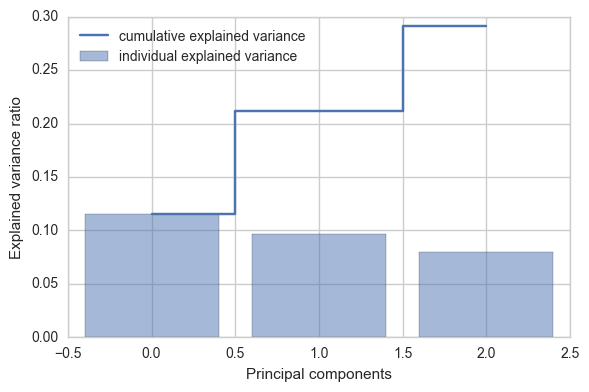

In [45]:
#check matching
observed_table_m, mapping = match(observed_table_m, mappingdf)
pca_model2=PCA(n_components=3)
X1=observed_table_m.as_matrix()
X_reduced1 = pca_model2.fit_transform(X1)
var_exp=pca_model2.explained_variance_ratio_
cum_var_exp = np.cumsum(pca_model2.explained_variance_ratio_)
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(3), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(3), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

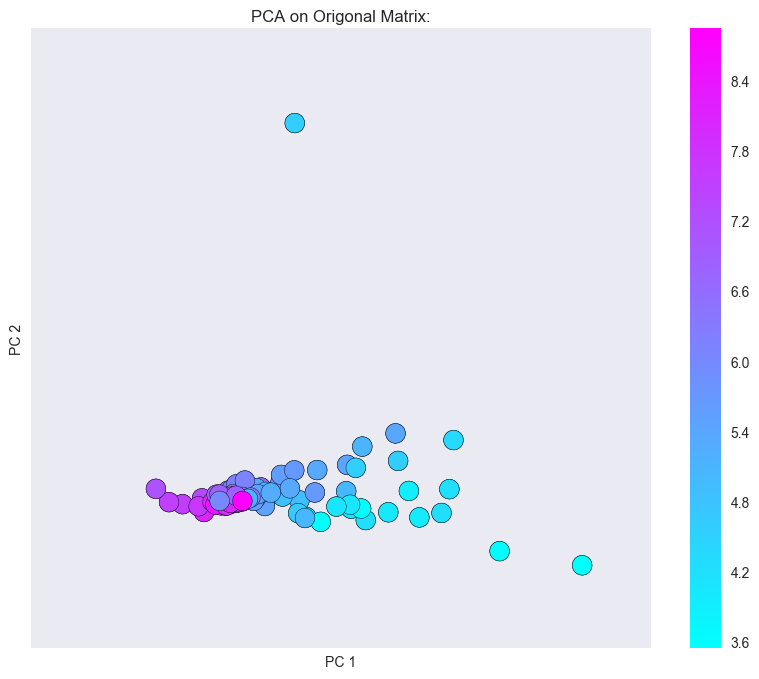

In [46]:
#plot pca
Y=mapping["pH"].tolist()
plt.figure(2, figsize=(10, 8))
plt.scatter(X_reduced1[:, 0], X_reduced1[:, 1], c=Y,cmap=plt.cm.cool,s=200)
p=plt.scatter(X_reduced1[:, 0], X_reduced1[:, 1], c=Y,cmap=plt.cm.cool,s=200)
plt.title("PCA on Origonal Matrix:")
plt.xlabel("PC 1", fontsize=10)
plt.xticks([])
plt.yticks([])
plt.ylabel("PC 2", fontsize=10)
plt.colorbar(p)
plt.show()

As you can see the zero impute data how low explained variance in the first three axis and a large outlier. 

#### PCA on Iterative SVD data, 100% dense

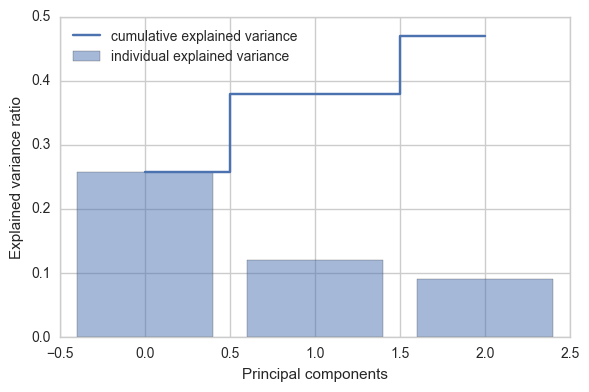

In [47]:
#check matching
observed_table_sni, mapping = match(observed_table_sni, mappingdf)
pca_model=PCA(n_components=3)
X2=observed_table_sni.as_matrix()
X_reduced2 = pca_model.fit_transform(X2)
var_exp=pca_model.explained_variance_ratio_
cum_var_exp = np.cumsum(pca_model.explained_variance_ratio_)
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(3), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(3), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

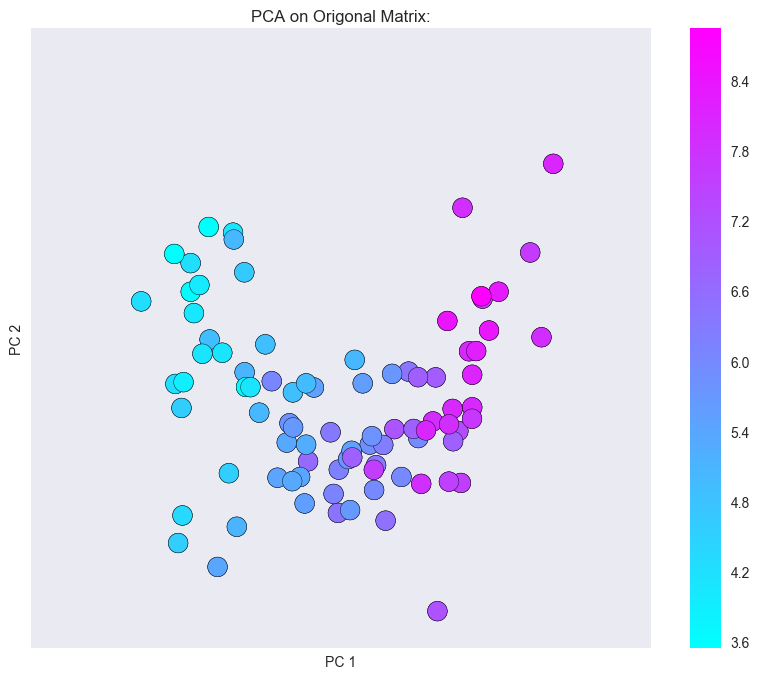

In [48]:
#plot pca
Y=mapping["pH"].tolist()
plt.figure(2, figsize=(10, 8))
plt.scatter(X_reduced2[:, 0], X_reduced2[:, 1], c=Y,cmap=plt.cm.cool,s=200)
p=plt.scatter(X_reduced2[:, 0], X_reduced2[:, 1], c=Y,cmap=plt.cm.cool,s=200)
plt.title("PCA on Origonal Matrix:")
plt.xlabel("PC 1", fontsize=10)
plt.xticks([])
plt.yticks([])
plt.ylabel("PC 2", fontsize=10)
plt.colorbar(p)
plt.show()

In the complete data the outlier is no longer present and the explained variance is vastly increased.

# Ward Clustering for Balance Trees Using 100% Dense Matrix 

Balance trees for compositional data is a very important component of 16S data analysis. One difficulty for balances is building a tree due to the sparsity induced from zero imputation. This dense matrix imputation can help solve this problem.  https://github.com/biocore/gneiss

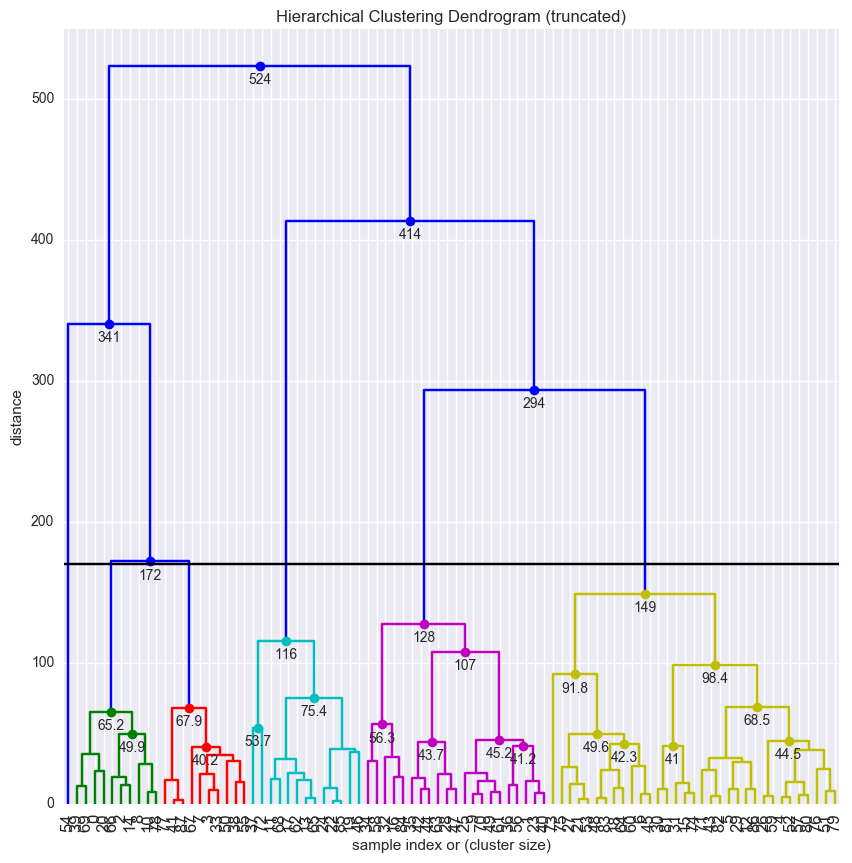

In [49]:
# generate the linkage matrix
Z = linkage(X_reduced2, 'ward')

# plot the dendrogram
plt.figure(figsize=(10,10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=88,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=40,
    max_d=170,
)
plt.show()